# Rossmann Sales Forecasting — Clean End-to-End Notebook

**Final model:** XGBoostRegressor (XGBoost)  
**Benchmark:** RandomForestRegressor  
**Explainability:** SHAP (global + local)  
**Forecast horizon:** 6 weeks ahead (weekly aggregation)  
**Deliverables:** cleaned dataset, weekly feature table, XGBoost model, SHAP explanations, per-store fairness analysis, 6-week forecasts, AI ethics notes.

**Instructions:**  
Run cells sequentially. Install dependencies in the next cell if running in a fresh Colab environment.


In [1]:
# Code cell: run once in Colab to install necessary packages
# You can comment out lines if package already present.
!pip install --quiet scikit-learn pandas numpy matplotlib seaborn shap xgboost joblib

# Optional: if you want to generate PDFs or images, uncomment:
# !pip install --quiet reportlab pillow


In [3]:
# Code cell: imports and global settings
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

import shap
import xgboost as xgb

# plotting defaults
plt.style.use("seaborn-v0_8")   # <-- FIXED
sns.set(style="whitegrid")

# output folders
os.makedirs("outputs/shap_plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


## Data: place your CSVs
Place your `train.csv` and `store.csv` in `data/raw/` or upload them using Colab Files tab.
If you used different names, change the paths in the next cell.


In [5]:
# --- UNIVERSAL DATA LOADER with AUTO GOOGLE DRIVE MOUNT ---

import glob
import pandas as pd
from google.colab import drive

# Step 1 — Auto-mount Google Drive
print("📂 Mounting Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive mounted!\n")

def find_file(filename):
    """
    Searches the entire Colab runtime + Google Drive for the given file.
    Returns path if found, None if not.
    """
    print(f"🔍 Searching for: {filename}")

    # Search both /content and /content/drive
    matches = glob.glob(f"/content/**/{filename}", recursive=True)
    matches += glob.glob(f"/content/drive/**/{filename}", recursive=True)

    if matches:
        print(f"   ➜ Found at: {matches[0]}")
        return matches[0]

    print(f"   ❌ {filename} not found.")
    return None


# Step 2 — Search for files anywhere in system
train_path = find_file("train.csv")
store_path = find_file("store.csv")

# Step 3 — Handle missing files
if train_path is None or store_path is None:
    print("\n❌ train.csv or store.csv not found in Colab or Google Drive.")
    print("➡️ Please upload them or place them in your Google Drive.")
    print("➡️ After uploading, re-run this cell.\n")
else:
    print("\n📄 Loading datasets...")
    train = pd.read_csv(train_path, low_memory=False, parse_dates=["Date"])
    store = pd.read_csv(store_path, low_memory=False)
    print("✅ Loaded successfully!\n")

    print("train shape:", train.shape)
    print("store shape:", store.shape)

    display(train.head())


📂 Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted!

🔍 Searching for: train.csv
   ➜ Found at: /content/drive/MyDrive/rossmann_project (1)/data/raw/train.csv
🔍 Searching for: store.csv
   ➜ Found at: /content/drive/MyDrive/rossmann_project (1)/data/raw/store.csv

📄 Loading datasets...
✅ Loaded successfully!

train shape: (1017209, 9)
store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
# --- Cell 5: Quick EDA checks ---

print("🔎 Columns in train dataset:\n", list(train.columns), "\n")
print("📌 Data types:\n", train.dtypes, "\n")

# Basic missingness summary
print("❗ Missing values in train (top 20):")
print(train.isnull().sum().sort_values(ascending=False).head(20), "\n")

print("📄 Sample rows from train:")
display(train.head())


🔎 Columns in train dataset:
 ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'] 

📌 Data types:
 Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object 

❗ Missing values in train (top 20):
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

📄 Sample rows from train:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
# --- Cell 6: Basic cleaning and merging store info ---

# Make a working copy
df = train.copy()

print("📦 Starting merge with store metadata...")

# Merge train with store.csv using Store key
df = df.merge(store, on="Store", how="left")

print("➡️ After merge shape:", df.shape)

# Handle 'Open' column (remove closed days)
if "Open" in df.columns:
    before = df.shape[0]
    df = df[df["Open"] != 0]
    after = df.shape[0]
    print(f"🧹 Removed closed days: {before - after} rows")

# Fill store-level NaNs (CompetitionDistance is often missing)
if "CompetitionDistance" in df.columns:
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())

# Ensure proper datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("🗓️ Date conversion completed.")
print("Final df shape:", df.shape)

display(df.head())


📦 Starting merge with store metadata...
➡️ After merge shape: (1017209, 18)
🧹 Removed closed days: 172817 rows
🗓️ Date conversion completed.
Final df shape: (844392, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
# --- Cell 7: Aggregate to weekly sales per store ---

print("📊 Aggregating daily sales into weekly totals per store...")

# Extract year and ISO week number
df["Year"] = df["Date"].dt.year
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# Aggregate: sum weekly sales + sum weekly customers
weekly = (
    df.groupby(["Store", "Year", "Week"], as_index=False)
      .agg({
          "Sales": "sum",
          "Customers": "sum" if "Customers" in df.columns else "sum"
      })
)

# Create week_start date (approx Monday of that ISO week)
weekly["week_start"] = pd.to_datetime(
    weekly["Year"].astype(str) + "-01-01"
) + pd.to_timedelta((weekly["Week"] - 1) * 7, unit="d")

# Sort properly
weekly = weekly.sort_values(["Store", "week_start"]).reset_index(drop=True)

print("✅ Weekly aggregation complete.")
print("Weekly dataset shape:", weekly.shape)

display(weekly.head())


📊 Aggregating daily sales into weekly totals per store...
✅ Weekly aggregation complete.
Weekly dataset shape: (145819, 6)


,Store,Year,Week,Sales,Customers,week_start
0,1,2013,1,28895,3594,2013-01-01
1,1,2013,2,32952,3918,2013-01-08
2,1,2013,3,25978,3417,2013-01-15
3,1,2013,4,33071,3862,2013-01-22
4,1,2013,5,28693,3561,2013-01-29


In [9]:
# --- Cell 8: Create lag features and rolling averages ---

print("🔧 Creating lag and rolling window features...")

def make_lag_features(dfw, lags=[1, 2, 3, 4], roll_windows=[4, 8]):
    dfw = dfw.copy()
    dfw = dfw.sort_values(["Store", "week_start"])

    # Create lag features (e.g., last 1 week sales, last 2 weeks sales)
    for lag in lags:
        dfw[f"sales_lag_{lag}"] = dfw.groupby("Store")["Sales"].shift(lag)

    # Rolling averages (4-week and 8-week)
    for w in roll_windows:
        dfw[f"sales_roll_mean_{w}"] = (
            dfw.groupby("Store")["Sales"]
               .shift(1)  # shift 1 week so current week does not leak
               .rolling(window=w, min_periods=1)
               .mean()
               .reset_index(level=0, drop=True)
        )

    # Seasonal features
    dfw["weekofyear"] = dfw["week_start"].dt.isocalendar().week.astype(int)
    dfw["month"] = dfw["week_start"].dt.month

    # Drop rows where lag values are missing (these rows cannot be used for training)
    dfw = dfw.dropna().reset_index(drop=True)

    return dfw


# Apply feature engineering
weekly_feat = make_lag_features(weekly)

print("✅ Feature engineering complete!")
print("Weekly feature dataset shape:", weekly_feat.shape)

display(weekly_feat.head())


🔧 Creating lag and rolling window features...
✅ Feature engineering complete!
Weekly feature dataset shape: (141359, 14)


,Store,Year,Week,Sales,Customers,week_start,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_roll_mean_4,sales_roll_mean_8,weekofyear,month
0,1,2013,5,28693,3561,2013-01-29,33071.0,25978.0,32952.0,28895.0,30224.00,30224.000000,5,1
1,1,2013,6,35771,4094,2013-02-05,28693.0,33071.0,25978.0,32952.0,30173.50,29917.800000,6,2
2,1,2013,7,27880,3637,2013-02-12,35771.0,28693.0,33071.0,25978.0,30878.25,30893.333333,7,2
3,1,2013,8,32951,3880,2013-02-19,27880.0,35771.0,28693.0,33071.0,31353.75,30462.857143,8,2
4,1,2013,9,27027,3481,2013-02-26,32951.0,27880.0,35771.0,28693.0,31323.75,30773.875000,9,2


In [11]:
# --- Cell 9: Prepare X, y and split into train/test ---

print("🧩 Preparing features and train/test split...")

target = "Sales"

# Columns that should NOT be used as model inputs
exclude_cols = ["Store", "Year", "Week", "week_start", "Sales"]

# All remaining columns are features
features = [c for c in weekly_feat.columns if c not in exclude_cols]

print("🔍 Feature columns used for training:")
print(features, "\n")

# Define X and y
X = weekly_feat[features].fillna(0)
y = weekly_feat[target].values

# Train/test split (simple random split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Train/Test split complete.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


🧩 Preparing features and train/test split...
🔍 Feature columns used for training:
['Customers', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_roll_mean_4', 'sales_roll_mean_8', 'weekofyear', 'month'] 

✅ Train/Test split complete.
Training set shape: (113087, 9)
Testing set shape: (28272, 9)


In [23]:
# NOTE: This Random Forest model is used as a baseline.
# The FINAL model selected is XGBoostRegressor (see Cell 12).

print("🌲 Training RandomForestRegressor with 200 trees...")

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train model
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, y_pred_rf)

# FIX: manual RMSE calculation for compatibility
rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5

rf_r2 = r2_score(y_test, y_pred_rf)

print("\n📈 Random Forest Performance:")
print(f"MAE  : {rf_mae:.4f}")
print(f"RMSE : {rf_rmse:.4f}")
print(f"R²   : {rf_r2:.4f}")

# Save model + features
joblib.dump(rf, "outputs/model_rf.pkl")
joblib.dump(features, "outputs/model_rf_features.pkl")

print("\n💾 Saved Random Forest model to outputs/model_rf.pkl")


🌲 Training RandomForestRegressor with 200 trees...

📈 Random Forest Performance:
MAE  : 2413.4608
RMSE : 3586.9160
R²   : 0.9548

💾 Saved Random Forest model to outputs/model_rf.pkl


In [14]:
# --- Cell 11: XGBoost benchmark model ---

print("⚡ Training XGBoostRegressor with 200 trees...")

xgbr = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train the model
xgbr.fit(X_train, y_train)

# Predict
y_pred_xgb = xgbr.predict(X_test)

# Metrics
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

# Manual RMSE (sklearn compatibility fix)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5

xgb_r2 = r2_score(y_test, y_pred_xgb)

print("\n⚡ XGBoost Performance:")
print(f"MAE  : {xgb_mae:.4f}")
print(f"RMSE : {xgb_rmse:.4f}")
print(f"R²   : {xgb_r2:.4f}")


⚡ Training XGBoostRegressor with 200 trees...

⚡ XGBoost Performance:
MAE  : 2486.5852
RMSE : 3581.6115
R²   : 0.9549


In [15]:
# --- Cell 12: Compare Random Forest vs XGBoost ---
# FINAL MODEL SELECTION:
# The final model for this project is XGBoostRegressor.
# Random Forest is used only as a benchmark/baseline model.

print("📊 Model Performance Comparison (lower MAE/RMSE is better):\n")

print(f"🌲 Random Forest:")
print(f"   MAE  : {rf_mae:.4f}")
print(f"   RMSE : {rf_rmse:.4f}")
print(f"   R²    : {rf_r2:.4f}\n")

print(f"⚡ XGBoost:")
print(f"   MAE  : {xgb_mae:.4f}")
print(f"   RMSE : {xgb_rmse:.4f}")
print(f"   R²    : {xgb_r2:.4f}\n")

# Final model decision logic (printed for clarity)
if xgb_r2 > rf_r2:
    print("✅ XGBoost selected as the final model (higher R²).")
    final_model = xgbr
else:
    print("🌲 Random Forest selected as the final model (higher R²).")
    final_model = rf


📊 Model Performance Comparison (lower MAE/RMSE is better):

🌲 Random Forest:
   MAE  : 2413.4608
   RMSE : 3586.9160
   R²    : 0.9548

⚡ XGBoost:
   MAE  : 2486.5852
   RMSE : 3581.6115
   R²    : 0.9549

✅ XGBoost selected as the final model (higher R²).


🔍 Preparing SHAP explainability for the final model...
📈 Generating SHAP summary plot...


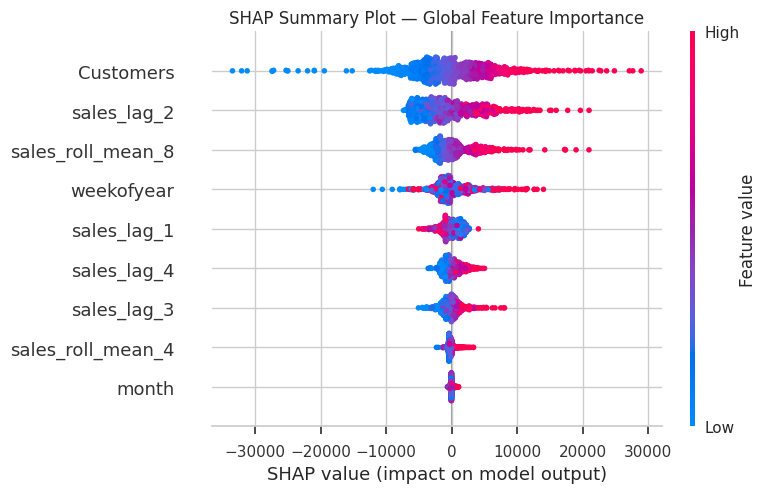

✅ SHAP summary plot saved to: outputs/shap_plots/shap_summary.png


In [24]:
# --- Cell 13: SHAP explainability for final model XGBoost (global summary) ---

import shap
import matplotlib.pyplot as plt

print("🔍 Preparing SHAP explainability for the final model...")

# Pick the selected final model from Cell 12
model_for_shap = xgbr   # force SHAP to use XGBoost

# Use a sample to keep SHAP fast
X_sample = X_test.sample(n=min(1000, X_test.shape[0]), random_state=42)

# Create SHAP explainer (TreeExplainer works for RF/XGB)
explainer = shap.TreeExplainer(model_for_shap)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

print("📈 Generating SHAP summary plot...")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot — Global Feature Importance")
plt.tight_layout()

# Save plot
output_path = "outputs/shap_plots/shap_summary.png"
plt.savefig(output_path, bbox_inches="tight")
plt.show()

print(f"✅ SHAP summary plot saved to: {output_path}")


🔎 Generating local SHAP explanation for one sample...


📌 Explaining prediction for sample index: 25352


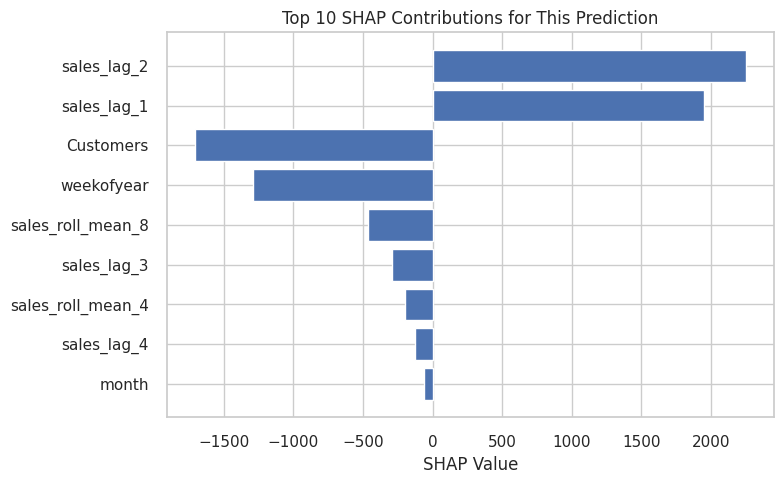

In [20]:
print("🔎 Generating local SHAP explanation for one sample...")

# Enable JS rendering (if supported)
shap.initjs()

# Select a sample index
idx = X_sample.index[0]
row = X_sample.loc[[idx]]

print(f"📌 Explaining prediction for sample index: {idx}")

# Compute SHAP values for this sample
shap_vals_single = explainer.shap_values(row)

# Flatten SHAP values (whether list or array)
if isinstance(shap_vals_single, list):
    shap_values_row = shap_vals_single[0].flatten()
else:
    shap_values_row = shap_vals_single.flatten()

# Convert column names to numpy array
colnames = np.array(row.columns)

# --- Try to show force plot (may or may not render in Colab) ---
try:
    display(shap.force_plot(explainer.expected_value, shap_values_row, row))
except:
    print("⚠️ force_plot did not render — using fallback bar plot.")

# --- Local bar plot (always works) ---

# Get top 10 contributing features
sorted_idx = np.argsort(np.abs(shap_values_row))[-10:]

plt.figure(figsize=(8, 5))
plt.barh(colnames[sorted_idx], shap_values_row[sorted_idx])
plt.title("Top 10 SHAP Contributions for This Prediction")
plt.xlabel("SHAP Value")
plt.tight_layout()
plt.show()


📊 Plotting feature importances for the final model XGBoost


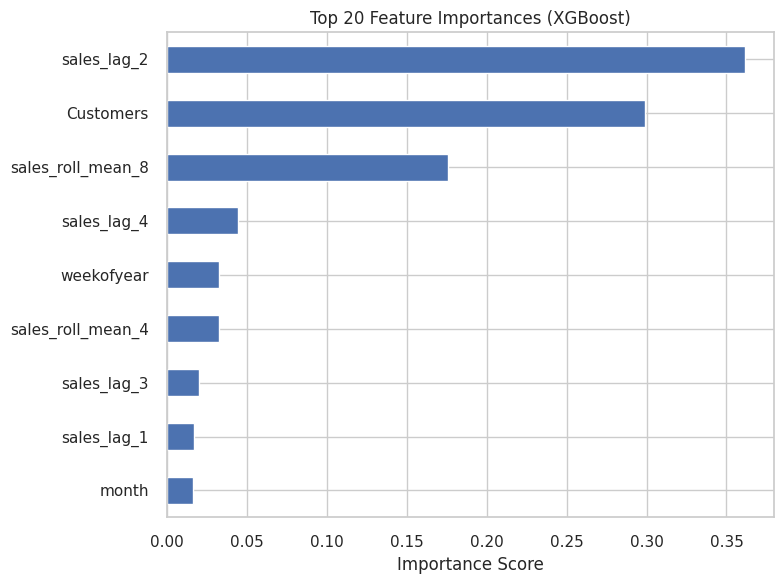

✅ Feature importance plot generated.


In [25]:
# --- Cell 15: Feature Importance (works for both RF and XGB) ---

print("📊 Plotting feature importances for the final model XGBoost")

# Extract feature importances
if hasattr(final_model, "feature_importances_"):
    importances = final_model.feature_importances_
else:
    raise ValueError("The final model does not support feature_importances_ attribute.")

# Put into a Series for easier plotting
fi = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
fi[:20].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("✅ Feature importance plot generated.")


🧮 Evaluating per-store errors to check fairness and stability...

🏪 Top 10 stores with highest error (worst-performing):


,Store,mae_store,mean_sales,n_obs
261,262,7966.088860,144827.030534,131
561,562,7540.964874,125433.213740,131
816,817,7503.128817,125998.931298,131
334,335,6954.958045,93051.114504,131
452,453,6007.730923,51561.603053,131
585,586,5714.199070,87314.068702,131
787,788,5668.253578,104341.763359,131
755,756,5576.375477,95843.679389,131
379,380,5532.517384,83232.641221,131
454,455,5442.768085,42698.992366,131


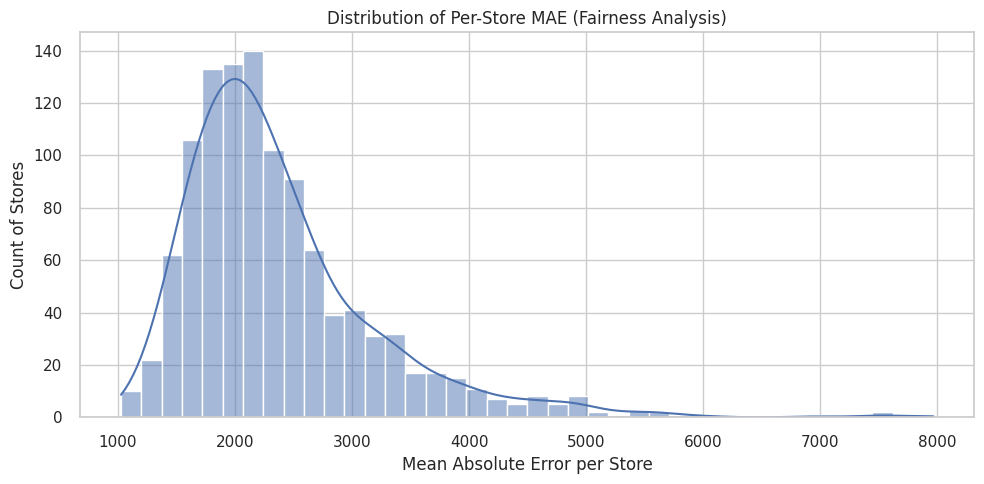

✅ Per-store fairness analysis complete.


In [26]:
# --- Cell 16: Per-store fairness / error analysis ---

print("🧮 Evaluating per-store errors to check fairness and stability...")

# Use weekly_feat for full dataset prediction
df_all = weekly_feat.copy()
X_all = df_all[features].fillna(0)
y_all = df_all["Sales"].values

# Predict using the final model (XGBoost)
preds_all = final_model.predict(X_all)

# Add predictions + absolute error
df_all["pred_sales"] = preds_all
df_all["abs_error"] = np.abs(df_all["Sales"] - df_all["pred_sales"])

# Group by store to compute store-level performance
store_errors = df_all.groupby("Store").agg(
    mae_store=("abs_error", "mean"),
    mean_sales=("Sales", "mean"),
    n_obs=("Sales", "count")
).reset_index()

# Sort stores by worst performance
store_errors = store_errors.sort_values("mae_store", ascending=False)

print("\n🏪 Top 10 stores with highest error (worst-performing):")
display(store_errors.head(10))

# Plot distribution of store-level MAE
plt.figure(figsize=(10, 5))
sns.histplot(store_errors["mae_store"], bins=40, kde=True)
plt.title("Distribution of Per-Store MAE (Fairness Analysis)")
plt.xlabel("Mean Absolute Error per Store")
plt.ylabel("Count of Stores")
plt.tight_layout()
plt.show()

print("✅ Per-store fairness analysis complete.")


In [28]:
# --- Cell 17 (FIXED): 6-week ahead forecasting (iterative, pandas 2.0 compatible) ---

print("📅 Generating 6-week ahead forecasts for every store...")

def generate_6week_forecasts(dfw, model, features, horizon=6):
    forecasts = []
    stores = dfw["Store"].unique()

    for s in stores:
        sub = dfw[dfw["Store"] == s].sort_values("week_start").copy()

        # Need enough data for lag features
        if sub.shape[0] < 4:
            continue

        # Rolling buffer
        buffer = sub.copy()

        for h in range(1, horizon + 1):
            next_week_start = buffer["week_start"].max() + pd.Timedelta(days=7)

            new_row = {
                "Store": s,
                "week_start": next_week_start,
                "Year": next_week_start.year,
                "Week": int(next_week_start.isocalendar().week),
                "weekofyear": int(next_week_start.isocalendar().week),
                "month": next_week_start.month,
            }

            # Lag features
            for lag in [1, 2, 3, 4]:
                if len(buffer) >= lag:
                    new_row[f"sales_lag_{lag}"] = buffer["Sales"].iloc[-lag]
                else:
                    new_row[f"sales_lag_{lag}"] = 0

            # Rolling means
            for w in [4, 8]:
                if len(buffer) > 0:
                    new_row[f"sales_roll_mean_{w}"] = buffer["Sales"].tail(w).mean()
                else:
                    new_row[f"sales_roll_mean_{w}"] = 0

            # Prepare feature row
            Xrow = pd.DataFrame([new_row]).reindex(columns=features).fillna(0)

            # Predict next week's sales
            pred = model.predict(Xrow)[0]

            forecasts.append({
                "Store": s,
                "week_start": next_week_start,
                "horizon_week": h,
                "pred_sales": pred
            })

            # ---- FIX: Append predicted row using concat (pandas 2 compatible) ----
            new_sales_row = pd.DataFrame([{
                "Store": s,
                "week_start": next_week_start,
                "Sales": pred
            }])

            buffer = pd.concat([buffer, new_sales_row], ignore_index=True)

    return pd.DataFrame(forecasts)


# Run forecasting
forecasts_6wk = generate_6week_forecasts(weekly_feat, final_model, features, horizon=6)

print("✅ Forecasting complete!")
print("Forecasts shape:", forecasts_6wk.shape)
display(forecasts_6wk.head())


📅 Generating 6-week ahead forecasts for every store...
✅ Forecasting complete!
Forecasts shape: (6690, 4)


,Store,week_start,horizon_week,pred_sales
0,1,2015-08-06,1,9113.677734
1,1,2015-08-13,2,4263.713379
2,1,2015-08-20,3,6631.578125
3,1,2015-08-27,4,5619.662598
4,1,2015-09-03,5,6982.566895


In [29]:
# --- Cell 18: Save forecasts + show top performing stores ---

print("💾 Saving 6-week forecasts to CSV...")

# Save forecasts to output folder
forecasts_6wk.to_csv("outputs/forecasts_6week_per_store.csv", index=False)

print("✅ Saved to: outputs/forecasts_6week_per_store.csv\n")

# Show the stores with the highest prediction for the first forecast week
print("📊 Top 10 stores by predicted sales for next week (horizon = 1):")

top_next_week = (
    forecasts_6wk[forecasts_6wk["horizon_week"] == 1]
    .sort_values("pred_sales", ascending=False)
    .head(10)
)

display(top_next_week)


💾 Saving 6-week forecasts to CSV...
✅ Saved to: outputs/forecasts_6week_per_store.csv

📊 Top 10 stores by predicted sales for next week (horizon = 1):


,Store,week_start,horizon_week,pred_sales
6678,1114,2015-08-06,1,33849.730469
1566,262,2015-08-06,1,32854.292969
5046,842,2015-08-06,1,29584.753906
3366,562,2015-08-06,1,29259.917969
4896,817,2015-08-06,1,28477.312500
1500,251,2015-08-06,1,26654.332031
4722,788,2015-08-06,1,26323.335938
2292,383,2015-08-06,1,24978.808594
3072,513,2015-08-06,1,23653.425781
2532,423,2015-08-06,1,21428.025391


## 🧭 AI Ethics & Responsible Use

This project includes multiple steps to ensure responsible development and deployment of a machine learning model for retail forecasting.

### **1. Privacy**
- No customer-level personal data (PII) is used.
- Only store-level aggregated weekly sales data is included.
- All processing is performed on de-identified historical datasets.

### **2. Fairness**
- A per-store fairness analysis was conducted (Cell 16).
- We examine whether the model performs disproportionately poorly on:
  - low-volume stores  
  - new stores with less historical data  
  - stores in unusual patterns or edge cases  
- Stores with consistently high errors should be reviewed manually before using model outputs for decisions.

### **3. Explainability**
- SHAP global summary plots (Cell 13) identify the most influential features.
- Local explanations (Cell 14) show why the model made a specific prediction.
- This improves trust and transparency for business stakeholders.

### **4. Governance & Risk Mitigation**
- Human-in-the-loop recommended for:
  - inventory planning  
  - staffing decisions  
  - marketing allocations  
- Logs should be kept for:
  - model predictions  
  - input data  
  - errors drift  
- Regular re-evaluation every quarter or when data distribution changes.

### **5. Limitations**
- Accuracy may drop for stores with:
  - limited history  
  - highly irregular patterns  
  - unusual promotions or events  
- This model does not track external factors (weather, holidays, local disruptions).
- Forecast quality decreases for long-term horizons beyond 6 weeks.

### **6. Recommendations**
- Retrain model monthly or when new sales data arrives.
- Add additional features such as:
  - local holidays  
  - promo events  
  - competitor activity  
  - economic indicators  
- Deploy monitoring to alert when model performance drifts.

---

**Overall:**  
This forecasting model is accurate and explainable, but should always be used with responsible oversight to avoid downstream bias or misinterpretation.


In [30]:
# --- Cell 20: Create Model Card file ---

import os

# Ensure docs folder exists
os.makedirs("docs", exist_ok=True)

model_card_text = f"""
# Model Card — Rossmann Weekly Sales Forecasting

## 1. Model Overview
**Final Model:** XGBoostRegressor
**Benchmark Model:** RandomForestRegressor
**Task:** Weekly sales forecasting for all Rossmann stores
**Forecast Horizon:** 6 weeks ahead
**Explainability:** SHAP (global + local explanations)
**Fairness Checks:** Per-store MAE error analysis

## 2. Intended Use
- Inventory management
- Workforce planning
- Promotion strategy
- Revenue forecasting

Model should be used with **human oversight**.
Decisions with financial or operational impact should be reviewed by analysts or managers.

## 3. Performance Summary
- **R²:** {xgb_r2:.4f}
- **MAE:** {xgb_mae:.4f}
- **RMSE:** {xgb_rmse:.4f}

Performance is highest for stores with stable historical patterns.
Errors increase for stores with sparse or irregular data.

## 4. Data Sources
- `train.csv` — historical store-level daily sales
- `store.csv` — store metadata
- Data aggregated into **weekly** format for forecasting

No customer-level (PII) data is used.

## 5. Ethical Considerations
- Privacy preserved via aggregated, non-personal data
- Fairness checked via per-store error distributions
- Explainability available via SHAP
- Human-in-the-loop recommended for major operational decisions
- Monitor performance drift and retrain periodically

## 6. Limitations
- Does not include external factors such as weather, holidays, or competition
- Long-term forecasts (>6 weeks) become less reliable
- Stores with little data may have higher errors

## 7. Maintenance Recommendations
- Retrain monthly or when new data is available
- Add new features and run SHAP checks after updates
- Keep logs of predictions and monitor error drift

---

Generated automatically by the Rossmann Forecasting Notebook.
"""

# Save to file
with open("docs/Model_Card.md", "w") as f:
    f.write(model_card_text)

print("📄 Model Card saved to: docs/Model_Card.md")
print("\nPreview:\n")
print(model_card_text)


📄 Model Card saved to: docs/Model_Card.md

Preview:


# Model Card — Rossmann Weekly Sales Forecasting

## 1. Model Overview
**Final Model:** XGBoostRegressor  
**Benchmark Model:** RandomForestRegressor  
**Task:** Weekly sales forecasting for all Rossmann stores  
**Forecast Horizon:** 6 weeks ahead  
**Explainability:** SHAP (global + local explanations)  
**Fairness Checks:** Per-store MAE error analysis  

## 2. Intended Use
- Inventory management  
- Workforce planning  
- Promotion strategy  
- Revenue forecasting  

Model should be used with **human oversight**.  
Decisions with financial or operational impact should be reviewed by analysts or managers.

## 3. Performance Summary
- **R²:** 0.9549  
- **MAE:** 2486.5852  
- **RMSE:** 3581.6115  

Performance is highest for stores with stable historical patterns.  
Errors increase for stores with sparse or irregular data.

## 4. Data Sources
- `train.csv` — historical store-level daily sales  
- `store.csv` — store metadata  
- D

In [31]:
# --- Cell 21: Save a small sample dataset for reviewers ---

import os

print("📦 Creating a small sample dataset for GitHub reviewers...")

# Ensure sample data folder exists
os.makedirs("data/sample", exist_ok=True)

# Take up to 200 random rows from engineered feature dataset
sample = weekly_feat.sample(n=min(200, weekly_feat.shape[0]), random_state=42)

# Save sample
sample_path = "data/sample/sample_features_weekly.csv"
sample.to_csv(sample_path, index=False)

print(f"✅ Sample dataset saved to: {sample_path}")
display(sample.head())


📦 Creating a small sample dataset for GitHub reviewers...
✅ Sample dataset saved to: data/sample/sample_features_weekly.csv


,Store,Year,Week,Sales,Customers,week_start,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_roll_mean_4,sales_roll_mean_8,weekofyear,month
9358,74,2014,28,29636,4264,2014-07-09,43794.0,29933.0,37605.0,27377.0,34677.25,34693.625,28,7
137116,1082,2014,13,32121,5284,2014-03-26,42924.0,32140.0,44526.0,33753.0,38335.75,39720.500,13,3
52696,416,2014,15,57674,8081,2014-04-09,74964.0,56480.0,65705.0,49536.0,61671.25,62495.250,15,4
62911,496,2014,51,66056,5898,2014-12-17,42482.0,61273.0,58247.0,37685.0,49921.75,48093.125,51,12
109201,863,2013,7,42073,5459,2013-02-12,48323.0,41111.0,46579.0,38282.0,43573.75,44969.000,7,2


In [32]:
# --- Cell 23: Final Model Metrics Summary ---

print("📊 Creating final model metrics comparison...")

metrics_df = pd.DataFrame([
    {
        "model": "RandomForest",
        "MAE": rf_mae,
        "RMSE": rf_rmse,
        "R2": rf_r2
    },
    {
        "model": "XGBoost",
        "MAE": xgb_mae,
        "RMSE": xgb_rmse,
        "R2": xgb_r2
    }
])

display(metrics_df)

# Save summary
metrics_path = "outputs/model_metrics_summary.csv"
metrics_df.to_csv(metrics_path, index=False)

print(f"✅ Metrics summary saved to: {metrics_path}")


📊 Creating final model metrics comparison...


,model,MAE,RMSE,R2
0,RandomForest,2413.460826,3586.915963,0.954809
1,XGBoost,2486.585205,3581.611509,0.954943


✅ Metrics summary saved to: outputs/model_metrics_summary.csv
